In [101]:
!pip install keras
!pip install visualkeras
!pip install pandas numpy matplotlib seaborn wordcloud nltk tensorflow
!pip install gensim scikit-learn tensorflow-hub plotly



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [102]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

import warnings
import string
from tensorflow import keras

#For Preprocessing
import re    # RegEx for removing non-letter characters
import nltk  #natural language processing
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *


import gensim.models
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import tensorflow as tf
from tensorflow.keras import initializers, preprocessing
import tensorflow_hub as hub
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import plotly.express as pxe

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [103]:

r_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Twitter_Data.csv')
t_data = pd.read_csv('../input/twitter-and-reddit-sentimental-analysis-dataset/Reddit_Data.csv')

In [104]:

print("Reddit description: \n",r_data.describe())
print("\n")
print("Twitter description: \n",r_data.describe())


Reddit description: 
             category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


Twitter description: 
             category
count  162973.000000
mean        0.225436
std         0.781279
min        -1.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000


In [105]:
print("Reddit dataset shape: ", r_data.shape)

print("Twitter dataset shape: ", t_data.shape)

Reddit dataset shape:  (162980, 2)
Twitter dataset shape:  (37249, 2)


In [106]:
print("Reddit first 5 rows:\n",r_data.head())

print("Twitter first 5 rows:\n",t_data.head())

Reddit first 5 rows:
                                           clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
Twitter first 5 rows:
                                        clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1


In [107]:
print("Null values in reddit: \n",r_data.isnull().sum())
print("\n")
print("Null values in Twitter: \n",t_data.isnull().sum())


Null values in reddit: 
 clean_text    4
category      7
dtype: int64


Null values in Twitter: 
 clean_comment    100
category           0
dtype: int64


### 2 Datasets one from twitter and from Reddit. Using both the data set for training and test validation, for this merging and renaming the columns.

In [108]:
import pandas as pd

# Rename 'clean_text' to 'clean_comment' in t_data
r_data.rename(columns={"clean_text": "clean_comment"}, inplace=True)

# Concatenate the dataframes
data = pd.concat([r_data, t_data], ignore_index=True)

print(data.head(10))


''' Merging Both data:
The reason behing merging both data is to give diversity in training set
and improving in general the performance of the model.'''

# Drop rows with missing values in 'clean_comment'
data = data.dropna(subset=['clean_comment'])
data = data.dropna(subset=['category'])
# Add a new column 'comment_length' containing the length of each comment
data['comment_length'] = data['clean_comment'].apply(len)

data.head(10)

data.isnull().sum()

                                       clean_comment  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0
5           kiya tho refresh maarkefir comment karo        0.0
6  surat women perform yagna seeks divine grace f...       0.0
7  this comes from cabinet which has scholars lik...       0.0
8  with upcoming election india saga going import...       1.0
9                         gandhi was gay does modi         1.0


clean_comment     0
category          0
comment_length    0
dtype: int64

In [109]:
import plotly.express as px
# Filter data for negative sentiment (-1)
negative_data = data[data['category'] == -1]

fig = px.histogram(negative_data, x='comment_length', title='Comment Length Distribution for Negative Sentiment',
                   labels={'comment_length': 'Comment Length'}, opacity=0.7, color_discrete_sequence=['green'])

fig.update_layout(showlegend=False)
fig.show()

# Filter data for positive sentiment (1)
positive_data = data[data['category'] == 1]

fig = px.histogram(positive_data, x='comment_length', title='Comment Length Distribution for Positive Sentiment',
                   labels={'comment_length': 'Comment Length'}, opacity=0.7, color_discrete_sequence=['blue'])

fig.update_layout(showlegend=False)
fig.show()

# Filter data for neutral sentiment (0)
neutral_data = data[data['category'] == 0]

fig = px.histogram(neutral_data, x='comment_length', title='Comment Length Distribution for Neutral Sentiment',
                   labels={'comment_length': 'Comment Length'}, opacity=0.7, color_discrete_sequence=['red'])

fig.update_layout(showlegend=False)
fig.show()

### Map Tweets and Reddits Category

In [110]:
data['category'] = data['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
data.head()

clean_comment  category  comment_length
0  when modi promised “minimum government maximum...  Negative             210
1  talk all the nonsense and continue all the dra...   Neutral              68
2  what did just say vote for modi  welcome bjp t...  Positive             117
3  asking his supporters prefix chowkidar their n...  Positive             212
4  answer who among these the most powerful world...  Positive              81

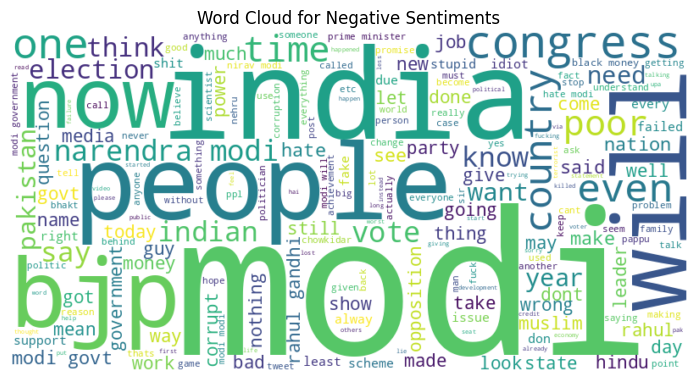

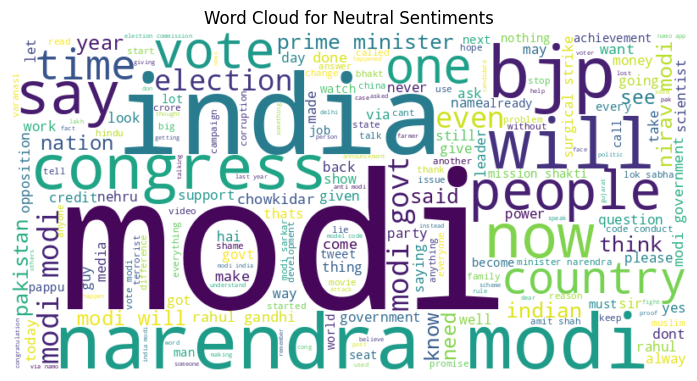

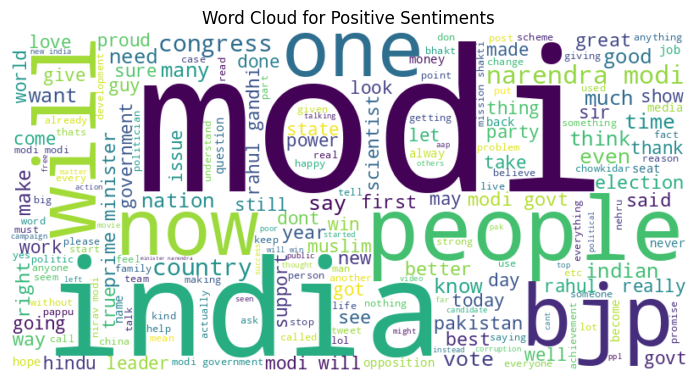

In [111]:

# Create a bar plot of sentiment distribution
sentiment_count = data['category'].value_counts()
fig_bar = pxe.bar(x=sentiment_count.index, y=sentiment_count.values, title='Sentiment Distribution',
                 labels={'x': 'Sentiment', 'y': 'Count'},
                 color=sentiment_count.index)
fig_bar.show()

# Create a pie chart of sentiment distribution
fig_pie = pxe.pie(data_frame=data, names='category', title='Sentiment Distribution',
                 color_discrete_map={'negative': 'green', 'neutral': 'red', 'positive': 'gray'})
fig_pie.show()

# Calculate the average comment length for each sentiment category
avg_comment_length = data.groupby('category')['comment_length'].mean().reset_index()

# Create a bar plot of average comment length by sentiment
fig_bar_avg = pxe.bar(data_frame=avg_comment_length, x='category', y='comment_length', title='Average Comment Length by Sentiment',
                     labels={'x': 'Sentiment', 'y': 'Average Comment Length'},
                     color='category')
fig_bar_avg.show()

print("\n")

#  word cloud for each sentiment category
from wordcloud import WordCloud
import matplotlib.pyplot as plt

sentiments = data['category'].unique()
for sentiment in sentiments:
    text = ' '.join(data[data['category'] == sentiment]['clean_comment'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiments')
    plt.tight_layout(pad=5)
    plt.show()

## Data Preprocessing

In [112]:
data.head()

clean_comment  category  comment_length
0  when modi promised “minimum government maximum...  Negative             210
1  talk all the nonsense and continue all the dra...   Neutral              68
2  what did just say vote for modi  welcome bjp t...  Positive             117
3  asking his supporters prefix chowkidar their n...  Positive             212
4  answer who among these the most powerful world...  Positive              81

In [113]:
def text_to_words(data):
    ''' Convert tweet text into a sequence of words '''
    # convert to lowercase
    text = data.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

print("\nOriginal tweet ->", data['clean_comment'][0])
print("\nProcessed tweet ->", text_to_words(data['clean_comment'][0]))



Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [115]:
# Apply data processing to each tweet
X = list(map(text_to_words, data['clean_comment']))
from sklearn.preprocessing import LabelEncoder

# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(data['category'])

print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


In [117]:
y = pd.get_dummies(data['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

## Tokenizing and Padding

In [121]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', data['clean_comment'][0])
X, tokenizer = tokenize_pad_sequences(data['clean_comment'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  41    2  394   67 1956 1026   45 2254    1 1132  217    1  169   32
  143  100   57   60 1049  169   49    3    9  517    3   49 2525    3
 2462    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [123]:
y = pd.get_dummies(data['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (120070, 50) (120070, 3)
Validation Set -> (40024, 50) (40024, 3)
Test Set -> (40024, 50) (40024, 3)


## BiDirectional Using Neural Networks

In [125]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

In [127]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 25, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                

## Training Evaluation


Accuracy  : 0.9248
Precision : 0.9270
Recall    : 0.9219


InvalidParameterError: The 'y_true' parameter of f1_score must be an array-like or a sparse matrix. Got 0.9270136952400208 instead.

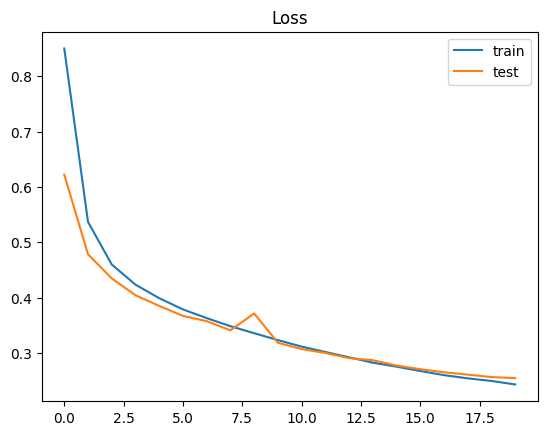

In [131]:
## training loss vs vaidation loss

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

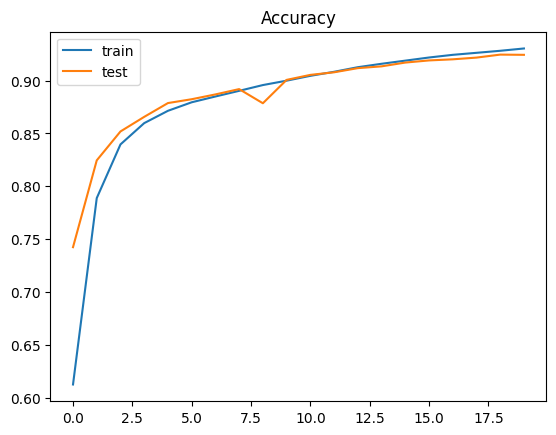

In [132]:
## training accuracy vs validation accuracy

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();


## Confusion Matrix

1251/1251 [==============================] - 6s 5ms/step


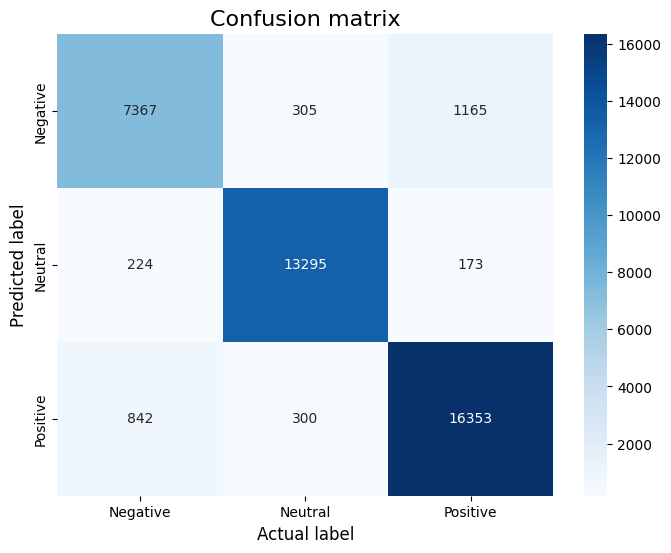

In [136]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Saving Model and Testing 

In [133]:
# Model save and load for the prediction
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

predict_class(['"I hate when I have to call and wake people up'])

predict_class(['The food was meh'])

predict_class(['He is a best minister india ever had seen'])

Best model saved
1/1 [==============================] - 1s 792ms/step
The predicted sentiment is Negative
1/1 [==============================] - 0s 27ms/step
The predicted sentiment is Neutral
1/1 [==============================] - 0s 28ms/step
The predicted sentiment is Positive
